In [42]:
# Evaluate model

# Common imports
import os
import glob
import numpy as np
from numpy import ones
import pandas as pd
#import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pathlib
import hashlib
import yaml
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)
# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# plot with cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Dotenv
#from dotenv import dotenv_values
# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *
from utils.datagenerators import *
from utils.networks import *
from utils.utils_predictions import *
from utils.score import * 

### I will evaluate firts daily predictions !

In [43]:
# load direct 1day lead time
unet_daily_pred = xr.open_dataset('predictions/daily/preds_unet.nc')
unet_conv_daily_pred = xr.open_dataset('predictions/daily/preds_simple_convlstm.nc')
unet_conv_ed_daily_pred = xr.open_dataset('predictions/daily/preds_convlstm_ed.nc')
resnet_daily_pred = xr.open_dataset('predictions/daily/preds_resnet.nc')
# Open weekly
#unet_W_pred = xr.open_dataset('predictions/weekly/preds_unet.nc')
#unet_conv_W_pred = xr.open_dataset('predictions/weekly/preds_unetconv.nc')
#resnet_W_pred = xr.open_dataset('predictions/weekly//preds_resnet.nc')

# load iterative
unet_pred_iter = xr.open_dataset('predictions/daily/preds_unet_ite.nc')
unet_conv_pred_iter = xr.open_dataset('predictions/daily/preds_simple_convlstm_int.nc')
unet_conv_ed_pred_iter = xr.open_dataset('predictions/daily/preds_convlstm_ed_int.nc')
resnet_pred_iter = xr.open_dataset('predictions/daily/preds_resnet_int.nc')

persistence = xr.open_dataset('tmp/daily_all/persistence.nc')
weekly_climatology = xr.open_dataset('tmp/daily_all/weekly_climatology.nc')

In [44]:
# Open true data-ERA5
#open data
conf = yaml.safe_load(open("config.yaml"))
dstot_train_D = xr.open_dataset('data/model1/dstot_train_daily.nc')
dstot_test_D = xr.open_dataset('data/model1/dstot_test_daily.nc')
#dstot_train_W = xr.open_dataset('data/model1/dstot_train_weekly.nc')
#dstot_test_W = xr.open_dataset('data/model1/dstot_test_weekly.nc')

In [4]:
# plot true and predictions
cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'

def plot_var(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
    
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, 
                  rasterized=True, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='vertical', extend='both', pad=0.01, shrink=0.90)
    ax.set_title(title)
    ax.coastlines(alpha=0.5)


In [5]:
date= '2021-07-01'

In [6]:
# select variables to plot:
dic_vars = {
     #'ws': None,
     'z': [500],              #let's use more geopotential levels
     'msl': None,
     't2m': None,
    # 'u': [500],
    # 'v': [500],
     'tcw': None
    }
units = ['m', 'Pa','K','kgm-2']
#units = ['m', 'Pa','K', 'm/s', 'm/s', 'kgm-2']
lim = [[5500, 6000], [101100, 104000], [260, 300],[0,35]]
cmaps = ['BuPu', 'BuPu', 'RdYlBu_r', 'RdYlBu_r']

In [12]:
def comparing_models(true, pred1, pred2, pred3, pred4, date, dic_vars, units, lim, cmaps, namef):
    
    nfigs = len(dic_vars)
    ncols = len(dic_vars)
    nrows = 1
    # TRUE
    fig, axes = plt.subplots(figsize=(24, 3), ncols=ncols, nrows=nrows, subplot_kw={'projection': ccrs.PlateCarree()})
    for a, (ivars, levels), un, r, cm in zip(axes.flatten(), dic_vars.items(), units, lim, cmaps):
        if levels is None:
            data = true[ivars].sel(time=date)
        else:
            data = true[ivars].sel(time=date, level=levels)
            
        plot_var(a, data, vmin=r[0], vmax=r[1],title= ['ERA5', ivars,un], cmap=cm)

    fig, axes = plt.subplots(figsize=(24, 3), ncols=ncols, nrows=nrows, subplot_kw={'projection': ccrs.PlateCarree()})
    for a, (ivars, levels), un, r, cm in zip(axes.flatten(), dic_vars.items(), units, lim, cmaps):
        if levels is None:
            data = pred1[ivars].sel(time=date)
        else:
            data = pred1[ivars].sel(time=date, level=levels)

        plot_var(a, data, vmin=r[0], vmax=r[1], title= ['Unet', ivars,un], cmap=cm)

    fig, axes = plt.subplots(figsize=(24, 3), ncols=ncols, nrows=nrows, subplot_kw={'projection': ccrs.PlateCarree()})
    for a, (ivars, levels), un, r, cm in zip(axes.flatten(), dic_vars.items(), units, lim, cmaps):
        if levels is None:
            data = pred2[ivars].sel(time=date)
        else:
            data = pred2[ivars].sel(time=date, level=levels)

        plot_var(a, data, vmin=r[0], vmax=r[1], title= ['UnteConv-Bottleneck', ivars,un], cmap=cm)
        
    fig, axes = plt.subplots(figsize=(24, 3), ncols=ncols, nrows=nrows, subplot_kw={'projection': ccrs.PlateCarree()})
    for a, (ivars, levels), un, r, cm in zip(axes.flatten(), dic_vars.items(), units, lim, cmaps):
        if levels is None:
            data = pred3[ivars].sel(time=date)
        else:
            data = pred3[ivars].sel(time=date, level=levels)

        plot_var(a, data, vmin=r[0], vmax=r[1], title= ['UnteConv-EnDe', ivars,un], cmap=cm)

    fig, axes = plt.subplots(figsize=(24, 3), ncols=ncols, nrows=nrows, subplot_kw={'projection': ccrs.PlateCarree()})  
    for a, (ivars, levels), un, r, cm in zip(axes.flatten(), dic_vars.items(), units, lim, cmaps):
        if levels is None:
            data = pred4[ivars].sel(time=date)
        else:
            data = pred4[ivars].sel(time=date, level=levels)

        plot_var(a, data,vmin=r[0], vmax=r[1], title= ['Resnet', ivars,un], cmap=cm)

    plt.savefig('figures/evaluate' + namef + '.pdf')


In [13]:
# compare daily

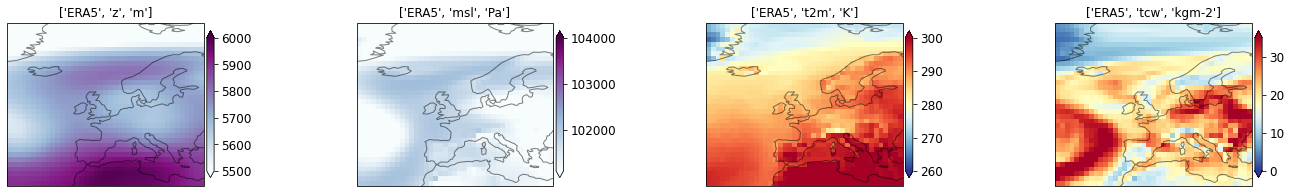

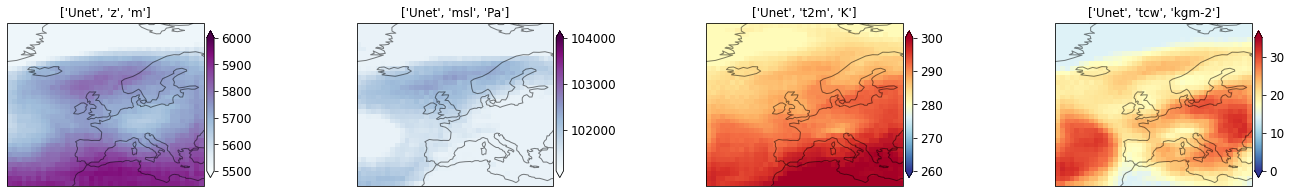

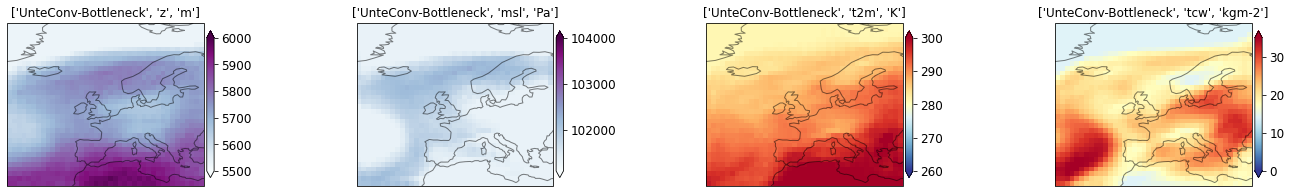

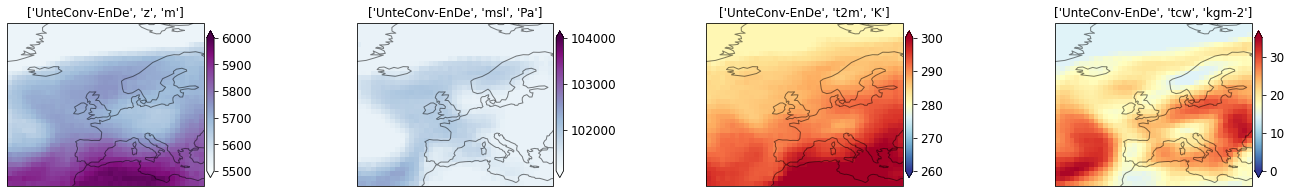

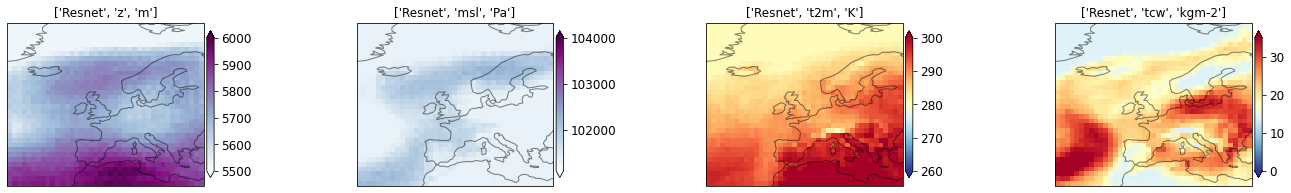

In [14]:
comparing_models(dstot_test_D, unet_daily_pred, unet_conv_daily_pred, unet_conv_ed_daily_pred, resnet_daily_pred, date, dic_vars, units, lim, cmaps, 'Daily')

In [47]:
# open S2S forecast--to be done!
dir_S2S = '/storage/workspaces/giub_hydro/hydro/S2S_data/raw_zarr/control/'

In [48]:
z500_s2s = xr.open_zarr(dir_S2S + 'forecast_S2S_z.zarr')

In [ ]:
###

In [45]:
valid_data = dstot_test_D

In [46]:
# Calculate RMSE

func = compute_weighted_rmse
rmse = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, 'D', compute_weighted_rmse).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    'UNet': evaluate_iterative_forecast(unet_pred_iter, valid_data, 'D' ,func).load(),
    'UNet-SimpleConv' : evaluate_iterative_forecast(unet_conv_pred_iter, valid_data, 'D' ,func).load(),
    'UNet-EnDe-Conv' : evaluate_iterative_forecast(unet_conv_ed_pred_iter, valid_data, 'D' ,func).load(),
    'Resnet': evaluate_iterative_forecast(resnet_pred_iter, valid_data, 'D' ,func).load()
})

In [47]:
func2 = compute_weighted_acc
acc = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, 'D', func2).load(),
    'Weekly clim.': func2(weekly_climatology, valid_data).load(),
    'UNet': evaluate_iterative_forecast(unet_pred_iter, valid_data, 'D' ,func2).load(),
    'UNet-SimpleConv' : evaluate_iterative_forecast(unet_conv_pred_iter, valid_data, 'D' ,func2).load(),
    'UNet-EnDe-Conv' : evaluate_iterative_forecast(unet_conv_ed_pred_iter, valid_data, 'D' ,func2).load(),
    'Resnet': evaluate_iterative_forecast(resnet_pred_iter, valid_data, 'D' ,func2).load()
})

In [48]:
def create_plot(score, var, save_fn=None, ax=None, legend=False, ylabel=None, title=None, ylim=None, mult_tp=1.):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    for exp, ds in score.items():
        s = ds.copy(deep=True)
        if var in s.variables:
            if var == 'tp': s[var] *= mult_tp
            if exp in ['Weekly clim.']:
                ax.axhline(s[var], ls='--', c=colors[exp], label=exp, lw=3)
            elif 'direct' in exp:
                ax.scatter(s['lead_time'], s[var], c=colors[exp], s=100, label=exp, lw=2, edgecolors='k', zorder=10)
            else:
                s[var].plot(c=colors[exp], label=exp, lw=3, ax=ax)
            
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(ylim)
    ax.set_xlim(0, 42)
    #ax.set_xticks([0, 24, 48, 72, 96, 120])
    #ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time [days]')
    
    if not save_fn is None: 
        plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
        fig.savefig(save_fn)

In [49]:
var='z'
plev=None
ax=None

In [50]:
colors = {
    'Persistence': '0.2',
    'Weekly clim.': '0.7',
    'UNet': '#984ea3',
    'UNet-SimpleConv': '#4daf4a',
    'UNet-EnDe-Conv': '#377eb8',
    'Resnet': '#ff7f00',
}

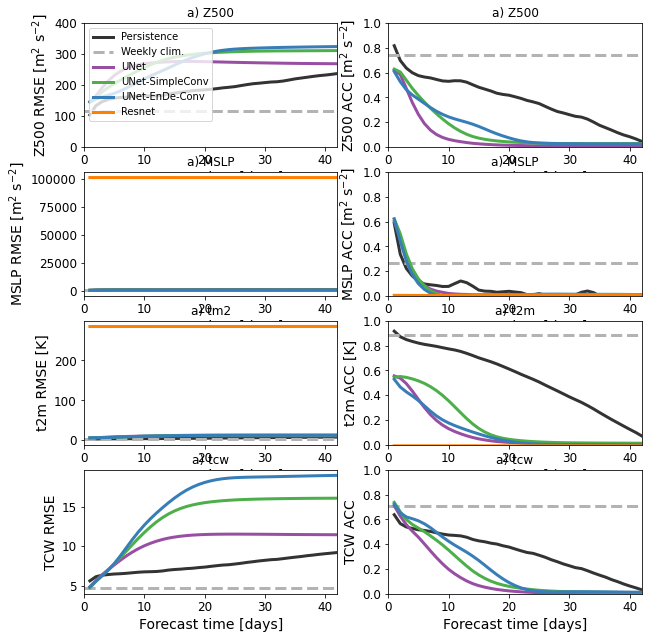

In [51]:
fig, (ax1) = plt.subplots(4, 2, figsize=(10, 10.5))
create_plot(rmse, 'z', ax=ax1[0,0], ylabel=r'Z500 RMSE [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 400))
create_plot(acc, 'z', ax=ax1[0,1], ylabel=r'Z500 ACC [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 1))
create_plot(rmse, 'msl', ax=ax1[1,0], ylabel=r'MSLP RMSE [m$^2$ s$^{-2}$]', title='a) MSLP')
create_plot(acc, 'msl', ax=ax1[1,1], ylabel=r'MSLP ACC [m$^2$ s$^{-2}$]', title='a) MSLP', ylim=(0, 1))
create_plot(rmse, 't2m', ax=ax1[2,0], ylabel=r't2m RMSE [K]', title='a) tm2')
create_plot(acc, 't2m', ax=ax1[2,1], ylabel=r't2m ACC [K]', title='a) t2m', ylim=(0, 1))
create_plot(rmse, 'tcw', ax=ax1[3,0], ylabel=r'TCW RMSE', title='a) tcw')
create_plot(acc, 'tcw', ax=ax1[3,1], ylabel=r'TCW ACC', title='a) tcw', ylim=(0, 1))
ax1[0,0].legend(loc=2, ncol=1, fontsize=10)
#ax2.legend(loc=2, ncol=1, fontsize=10)